<a href="https://colab.research.google.com/github/saktiworkstation/Deteksi-Dini-Depresi-dengan-4-Model-ML/blob/main/FP_bdpal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, mean, stddev, count, when, isnan
from pyspark.ml.clustering import GaussianMixture, KMeans
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
spark = SparkSession.builder.appName("DepressionDetection").getOrCreate()

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/AI Lanjut/dataset/depression_data.csv", header=True)

In [ ]:
df.show(5)

+----------------+---+--------------+-----------------+------------------+--------------+-----------------------+-----------------+---------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|            Name|Age|Marital Status|  Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|   Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|
+----------------+---+--------------+-----------------+------------------+--------------+-----------------------+-----------------+---------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|Christine Barker| 31|       Married|Bachelor's Degree|                 2|    Non-smoker|        

#Pre-Processing

In [ ]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Education Level: string (nullable = true)
 |-- Number of Children: string (nullable = true)
 |-- Smoking Status: string (nullable = true)
 |-- Physical Activity Level: string (nullable = true)
 |-- Employment Status: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Alcohol Consumption: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Sleep Patterns: string (nullable = true)
 |-- History of Mental Illness: string (nullable = true)
 |-- History of Substance Abuse: string (nullable = true)
 |-- Family History of Depression: string (nullable = true)
 |-- Chronic Medical Conditions: string (nullable = true)



In [ ]:
df.describe().show()

+-------+-----------+------------------+--------------+----------------+------------------+--------------+-----------------------+-----------------+------------------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|summary|       Name|               Age|Marital Status| Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|            Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|
+-------+-----------+------------------+--------------+----------------+------------------+--------------+-----------------------+-----------------+------------------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|  count|     41376

In [ ]:
missing_data = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Missing data for each column:")
missing_data.show()

Missing data for each column:
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|Name|Age|Marital Status|Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|   0|  0|             0|              0|                 0|             0|                      0|                0| 

In [ ]:
duplicates = (
    df.groupBy(df.columns)
    .count()
    .filter("count > 1")
)

# Tampilkan duplikat
duplicates.show()

+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+-----+
|Name|Age|Marital Status|Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|count|
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+-----+
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+------

In [ ]:
numerical_columns = ['Age', 'Income', 'Number of Children']
categorical_columns = [
    "Marital Status", "Education Level", "Smoking Status", "Physical Activity Level",
    "Employment Status", "Dietary Habits", "Sleep Patterns",
    "History of Mental Illness", "History of Substance Abuse",
    "Family History of Depression", "Chronic Medical Conditions"
]

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index").fit(df) for col in categorical_columns]
for indexer in indexers:
    df = indexer.transform(df)

encoded_features = [f"{col}_Index" for col in categorical_columns]

In [ ]:
from pyspark.sql.types import IntegerType

for col in numerical_columns:
    df = df.withColumn(col, df[col].cast(IntegerType()))

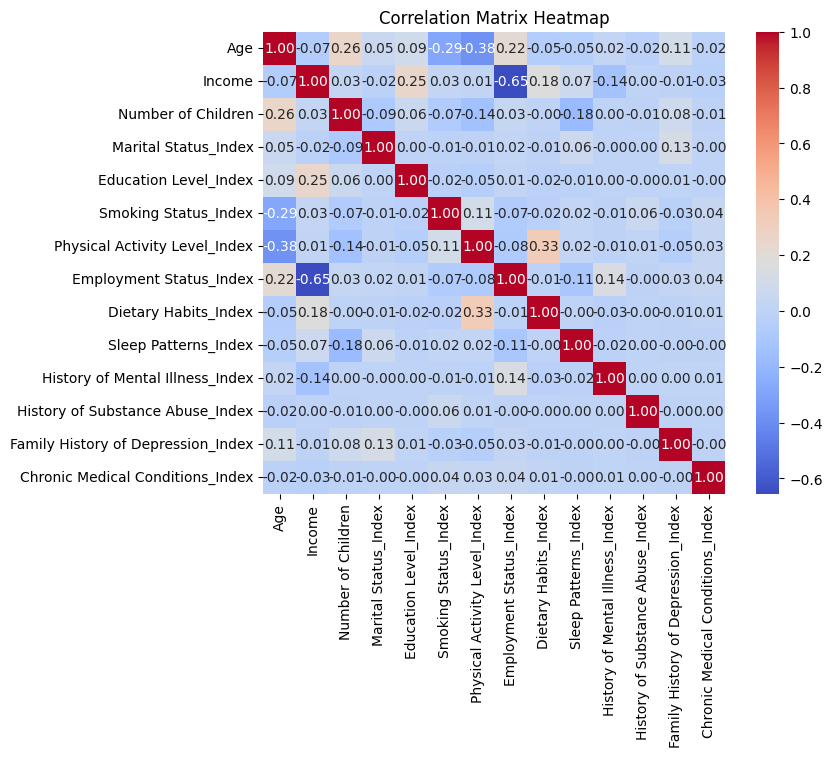

In [ ]:
encode_col = numerical_columns  + encoded_features
encode_df = df.select(encode_col)

# Mengonversi DataFrame PySpark ke Pandas untuk analisis korelasi
pandas_encode_df = encode_df.toPandas()

# Menghitung matriks korelasi
correlation_matrix = pandas_encode_df.corr()

# Visualisasi matriks korelasi menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
pandas_encode_df.to_csv('/content/drive/MyDrive/AI Lanjut/dataset/encoded_data.csv', index=False)

#EDA

In [ ]:
import pandas as pd
encode_df = pd.read_csv('/content/drive/MyDrive/AI Lanjut/dataset/encoded_data.csv')

In [ ]:
encode_df.columns

Index(['Age', 'Income', 'Number of Children', 'Marital Status_Index',
       'Education Level_Index', 'Smoking Status_Index',
       'Physical Activity Level_Index', 'Employment Status_Index',
       'Dietary Habits_Index', 'Sleep Patterns_Index',
       'History of Mental Illness_Index', 'History of Substance Abuse_Index',
       'Family History of Depression_Index',
       'Chronic Medical Conditions_Index'],
      dtype='object')

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(encode_df["History of Mental Illness_Index"], labels=encode_df["Age"], autopct='%1.1f%%', startangle=140)
plt.title("Pie Chart of History of Mental Illness_Index by Age")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="Income", y="History of Mental Illness_Index", data=encode_df, marker="o", color="blue")
plt.title("Line Chart of History of Mental Illness_Index by Income")
plt.xlabel("Income")
plt.ylabel("History of Mental Illness_Index")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x="Employment Status_Index", y="History of Mental Illness_Index", data=encode_df, palette="viridis")
plt.title("Bar Chart of History of Mental Illness_Index by Employment Status_Index")
plt.xlabel("Employment Status_Index")
plt.ylabel("History of Mental Illness_Index")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="Education Level_Index", y="History of Mental Illness_Index", data=encode_df, marker="o", color="blue")
plt.title("Line Chart of History of Mental Illness_Index by Education Level_Index")
plt.xlabel("Education Level_Index")
plt.ylabel("History of Mental Illness_Index")
plt.show()

In [ ]:
feature_columns = numerical_columns  + encoded_features
feature_columns

['Age',
 'Income',
 'Number of Children',
 'Marital Status_Index',
 'Education Level_Index',
 'Smoking Status_Index',
 'Physical Activity Level_Index',
 'Employment Status_Index',
 'Dietary Habits_Index',
 'Sleep Patterns_Index',
 'History of Mental Illness_Index',
 'History of Substance Abuse_Index',
 'Family History of Depression_Index',
 'Chronic Medical Conditions_Index']

In [ ]:
from pyspark.ml.stat import Correlation

vector_col = "features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol=vector_col)
assembled_data = assembler.transform(df)

In [ ]:
assembled_data.select("Name", "features").show(5, truncate=False)

+----------------+--------------------------------------------------------------+
|Name            |features                                                      |
+----------------+--------------------------------------------------------------+
|Christine Barker|[31.0,26265.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0]|
|Jacqueline Lewis|(14,[0,1,2,4,10,13],[55.0,42710.0,1.0,1.0,1.0,1.0])           |
|Shannon Church  |(14,[0,1,2,3,4,9,12],[78.0,125332.0,1.0,2.0,3.0,2.0,1.0])     |
|Charles Jordan  |[58.0,9992.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0] |
|Michael Rich    |[18.0,8595.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0] |
+----------------+--------------------------------------------------------------+
only showing top 5 rows



#Cluster

<h1>K-Means</h1>

In [ ]:
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="prediction_kmeans")
model_kmeans = kmeans.fit(assembled_data)

In [ ]:
predictions_kmeans = model_kmeans.transform(assembled_data)

In [ ]:
from pyspark.sql.functions import col, when

# Menambahkan kolom Stress_Level
predictions_kmeans = predictions_kmeans.withColumn(
    "Stress_Level",
    when(col("prediction_kmeans") == 0, "Low")
    .when(col("prediction_kmeans") == 1, "Moderate")
    .otherwise("High")
)


In [ ]:
predictions_kmeans.select("Name", "features", "prediction_kmeans", "Stress_Level").show()

+-------------------+--------------------+-----------------+------------+
|               Name|            features|prediction_kmeans|Stress_Level|
+-------------------+--------------------+-----------------+------------+
|   Christine Barker|[31.0,26265.0,2.0...|                0|         Low|
|   Jacqueline Lewis|(14,[0,1,2,4,10,1...|                0|         Low|
|     Shannon Church|(14,[0,1,2,3,4,9,...|                2|        High|
|     Charles Jordan|[58.0,9992.0,3.0,...|                0|         Low|
|       Michael Rich|[18.0,8595.0,0.0,...|                0|         Low|
|         Kathy Hill|(14,[0,1,3,4,5,6,...|                0|         Low|
|    Crystal Delgado|[60.0,22565.0,1.0...|                0|         Low|
|     Charles Kaiser|(14,[0,1,3,4,6,9]...|                0|         Low|
|     Kathryn Taylor|(14,[0,1,3,6,8,9,...|                1|    Moderate|
|Alexander Hernandez|(14,[0,1,2,9,10],...|                1|    Moderate|
|       Scott Butler|[70.0,28528.0,1.0

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Menggunakan evaluator untuk menghitung Silhouette Score
evaluator = ClusteringEvaluator(predictionCol="prediction_kmeans", featuresCol="features")
silhouette_score = evaluator.evaluate(predictions_kmeans)

print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.7964481525709927


<h1>Gaussion Mixture</h1>

In [ ]:
gmm = GaussianMixture(k=3, featuresCol="features", predictionCol="prediction_gmn")
model_gmn = gmm.fit(assembled_data)

In [ ]:
predictions_gmn = model_gmn.transform(assembled_data)

In [ ]:
from pyspark.sql.functions import col, when

# Menambahkan kolom Stress_Level
predictions_gmn = predictions_gmn.withColumn(
    "Stress_Level",
    when(col("prediction_gmn") == 0, "Low")
    .when(col("prediction_gmn") == 1, "Moderate")
    .otherwise("High")
)


In [ ]:
predictions_gmn.select("Name", "features", "prediction_gmn", "Stress_Level").show()

print("Gaussian Mixture Model Parameters:")
print(f"Weights: {model_gmn.weights}")
print("Cluster Centers (Means):")
model_gmn.gaussiansDF.show()

+-------------------+--------------------+--------------+------------+
|               Name|            features|prediction_gmn|Stress_Level|
+-------------------+--------------------+--------------+------------+
|   Christine Barker|[31.0,26265.0,2.0...|             1|    Moderate|
|   Jacqueline Lewis|(14,[0,1,2,4,10,1...|             2|        High|
|     Shannon Church|(14,[0,1,2,3,4,9,...|             2|        High|
|     Charles Jordan|[58.0,9992.0,3.0,...|             1|    Moderate|
|       Michael Rich|[18.0,8595.0,0.0,...|             0|         Low|
|         Kathy Hill|(14,[0,1,3,4,5,6,...|             2|        High|
|    Crystal Delgado|[60.0,22565.0,1.0...|             1|    Moderate|
|     Charles Kaiser|(14,[0,1,3,4,6,9]...|             2|        High|
|     Kathryn Taylor|(14,[0,1,3,6,8,9,...|             2|        High|
|Alexander Hernandez|(14,[0,1,2,9,10],...|             2|        High|
|       Scott Butler|[70.0,28528.0,1.0...|             1|    Moderate|
|     

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluator untuk menghitung Silhouette Score
evaluator = ClusteringEvaluator(predictionCol="prediction_gmn", featuresCol="features")
silhouette_score = evaluator.evaluate(predictions_gmn)

print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.011203413416420081


#Classification

<h1>Gradient Boost tree</h1>

In [ ]:
df.show(5, truncate=False)

+----------------+---+--------------+-----------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+--------------------+---------------------+--------------------+-----------------------------+-----------------------+--------------------+--------------------+-------------------------------+--------------------------------+----------------------------------+--------------------------------+
|Name            |Age|Marital Status|Education Level  |Number of Children|Smoking Status|Physical Activity Level|Employment Status|Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|Marital Status_Index|Education Level_Index|Smoking Status_Index|Physical Activity Level_Index|Employment Status_

In [ ]:
categorical_columns = [
    "Marital Status", "Education Level", "Smoking Status", "Physical Activity Level",
    "Employment Status", "Dietary Habits", "Sleep Patterns",
    "History of Mental Illness", "History of Substance Abuse",
    "Family History of Depression", "Chronic Medical Conditions"
]
for col_name in categorical_columns:
    df = df.fillna({col_name: "Unknown"})

In [ ]:
label_column = "History of Mental Illness_Index"
encoded_features = [f"{col}_Index" for col in categorical_columns if col != "History of Mental Illness"]
numerical_features = ["Age", "Number of Children", "Income"]

In [ ]:
assembler = VectorAssembler(inputCols=numerical_features, outputCol="raw_features")
raw_data = assembler.transform(df)

scaler = MinMaxScaler(inputCol="raw_features", outputCol="scaled_features")
scaler_model = scaler.fit(raw_data)
scaled_data = scaler_model.transform(raw_data)

In [ ]:
final_assembler = VectorAssembler(inputCols=["scaled_features"] + encoded_features, outputCol="features")
final_data = final_assembler.transform(scaled_data).select("features", label_column)

In [ ]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
gbt = GBTClassifier(labelCol=label_column, featuresCol="features", maxIter=50)

Penerapan Hyperparameter tunning dengan CrossValidator

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

crossval = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cv_model = crossval.fit(train_data)

In [ ]:
predictions = cv_model.transform(test_data)

accuracy = evaluator.evaluate(predictions)
print(f"Test Set Accuracy: {accuracy:.4f}")

predictions.select("features", label_column, "prediction").show()

Test Set Accuracy: 0.6942
+--------------------+-------------------------------+----------+
|            features|History of Mental Illness_Index|prediction|
+--------------------+-------------------------------+----------+
|(13,[0,1,2],[0.03...|                            0.0|       0.0|
|(13,[0,1,2],[0.06...|                            0.0|       0.0|
|(13,[0,1,2],[0.06...|                            0.0|       0.0|
|(13,[0,1,2],[0.11...|                            1.0|       0.0|
|(13,[0,1,2],[0.14...|                            0.0|       0.0|
|(13,[0,1,2],[0.14...|                            0.0|       0.0|
|(13,[0,1,2],[0.17...|                            0.0|       0.0|
|(13,[0,1,2],[0.19...|                            1.0|       0.0|
|(13,[0,1,2],[0.20...|                            0.0|       0.0|
|(13,[0,1,2],[0.20...|                            1.0|       0.0|
|(13,[0,1,2],[0.20...|                            1.0|       0.0|
|(13,[0,1,2],[0.20...|                            

In [ ]:
best_model = cv_model.bestModel
print("Feature Importances:")
print(best_model.featureImportances)

Feature Importances:
(13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.08027928983387216,0.02489069886003383,0.19057300895963467,0.026254423485943618,0.13786083513292677,0.08962726239228086,0.02630171995871756,0.3274195288418778,0.029557746648842878,0.028046180715881778,0.009631382114941101,0.01184185265218266,0.017716070402864256])


#<h1>Klassifikasi 2</h1>

In [ ]:
label_column = "History of Mental Illness_Index"
encoded_features = [f"{col}_Index" for col in categorical_columns if col != "History of Mental Illness"]

In [ ]:
assembler = VectorAssembler(inputCols=encoded_features, outputCol="features")

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol=label_column, numTrees=100)

In [ ]:
pipeline = Pipeline(stages=[assembler, rf])

In [ ]:
train_data_rf, test_data_rf = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
model_rf = pipeline.fit(train_data_rf)

In [ ]:
predictions_rf = model_rf.transform(test_data_rf)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)

print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.70


In [ ]:
predictions_rf.select("features", label_column, "prediction").show()

+--------------------+-------------------------------+----------+
|            features|History of Mental Illness_Index|prediction|
+--------------------+-------------------------------+----------+
|(10,[0,3,5,6,7],[...|                            1.0|       0.0|
|(10,[2,5,7],[2.0,...|                            0.0|       0.0|
|(10,[0,2,3,5,6],[...|                            1.0|       0.0|
|[0.0,1.0,1.0,1.0,...|                            0.0|       0.0|
|(10,[1,5,6],[2.0,...|                            0.0|       0.0|
|[1.0,1.0,1.0,2.0,...|                            0.0|       0.0|
|(10,[1,4,7,8],[1....|                            1.0|       0.0|
|(10,[2,4,9],[1.0,...|                            0.0|       0.0|
|(10,[1,6,8],[2.0,...|                            0.0|       0.0|
|[1.0,1.0,1.0,2.0,...|                            0.0|       0.0|
|(10,[1,2,6],[2.0,...|                            1.0|       0.0|
|(10,[1,2,3,7],[2....|                            0.0|       0.0|
|[0.0,4.0,

#Stop Session

In [ ]:
# 12. Menutup SparkSession
spark.stop()

#Kesimpulan

K-Means dan RandomForest pilihan terbaik, kalo gak percaya liat aja sendiri pak!!!